In [1]:
import os, math, time, random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from pathlib import Path
import html
import random

# 可选：画图
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
@dataclass
class CFG:
    data_dir: str = r"./wmt_data"
    csv_file: str = "wmt_zh_en_training_corpus.csv"

    # 从同一个文件切分
    train_ratio: float = 0.98
    valid_ratio: float = 0.01
    test_ratio:  float = 0.01
    seed: int = 42

cfg = CFG()
csv_path = Path(cfg.data_dir) / cfg.csv_file
csv_path


WindowsPath('wmt_data/wmt_zh_en_training_corpus.csv')

In [3]:
def preview_file(path, n=5):
    path = Path(path)
    print("==>", path.resolve())
    if not path.exists():
        print("❌ 文件不存在")
        return
    with path.open("r", encoding="utf-8") as f:
        for i in range(n):
            line = f.readline()
            if not line:
                break
            print(f"[{i}] {line.rstrip()[:220]}")

preview_file(csv_path, n=5)


==> C:\Users\31392\Desktop\writebyhand\wmt_data\wmt_zh_en_training_corpus.csv
[0] 0,1
[1] 表演 的 明星 是 X 女孩 团队 — — 由 一对 具有 天才 技艺 的 艳舞 女孩 们 组成 ， 其中 有些 人 受过 专业 的 训练 。,"the show stars the X Girls - a troupe of talented topless dancers , some of whom are classically trained ."
[2] 表演 的 压轴戏 是 闹剧 版 《 天鹅湖 》 ， 男女 小 人们 身着 粉红色 的 芭蕾舞 裙 扮演 小天鹅 。,the centerpiece of the show is a farcical rendition of Swan Lake in which male and female performers dance in pink tutus and imitate swans .
[3] 表演 和 后期制作 之间 的 屏障 被 清除 了 ， 这 对 演员 来说 一样 大有裨益 。,the removal of the barrier between performance and post @-@ production was just as helpful for the actors .
[4] （ 表演 或 背诵 时 ） 通过 暗示 下面 忘记 或 记地 不准 的 东西 来 帮助 某人 。,assist ( somebody acting or reciting ) by suggesting the next words of something forgotten or imperfectly learned .


In [4]:
def load_pairs_from_csv_first_comma(path: str | Path, max_rows: int | None = None):
    path = Path(path)
    pairs = []

    with path.open("r", encoding="utf-8") as f:
        for line_idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue

            # 跳过表头：0,1 或 "0","1"
            if line_idx == 0:
                head = line.replace('"', "").replace(" ", "")
                if head == "0,1":
                    continue

            # 找第一个逗号
            k = line.find(",")
            if k == -1:
                continue

            src = line[:k].strip()
            tgt = line[k+1:].strip()

            # 去两侧引号（若有）
            if len(src) >= 2 and src[0] == '"' and src[-1] == '"':
                src = src[1:-1].strip()
            if len(tgt) >= 2 and tgt[0] == '"' and tgt[-1] == '"':
                tgt = tgt[1:-1].strip()

            # 反转义：&apos; &quot; 等
            src = html.unescape(src)
            tgt = html.unescape(tgt)

            if src and tgt:
                pairs.append((src, tgt))

            if max_rows is not None and len(pairs) >= max_rows:
                break

    return pairs

pairs_all = load_pairs_from_csv_first_comma(csv_path, max_rows=None)
len(pairs_all), pairs_all[0]


(24752356,
 ('表演 的 明星 是 X 女孩 团队 — — 由 一对 具有 天才 技艺 的 艳舞 女孩 们 组成 ， 其中 有些 人 受过 专业 的 训练 。',
  'the show stars the X Girls - a troupe of talented topless dancers , some of whom are classically trained .'))

In [5]:
def split_train_valid_test(pairs, train_ratio=0.98, valid_ratio=0.01, test_ratio=0.01, seed=42):
    assert abs((train_ratio + valid_ratio + test_ratio) - 1.0) < 1e-6, "比例之和必须为 1"
    pairs = list(pairs)
    rnd = random.Random(seed)
    rnd.shuffle(pairs)

    n = len(pairs)
    n_train = int(n * train_ratio)
    n_valid = int(n * valid_ratio)
    # 剩下的都给 test，避免四舍五入导致总数不一致
    n_test  = n - n_train - n_valid

    train_pairs = pairs[:n_train]
    valid_pairs = pairs[n_train:n_train+n_valid]
    test_pairs  = pairs[n_train+n_valid:]

    return train_pairs, valid_pairs, test_pairs

train_pairs, valid_pairs, test_pairs = split_train_valid_test(
    pairs_all,
    train_ratio=cfg.train_ratio,
    valid_ratio=cfg.valid_ratio,
    test_ratio=cfg.test_ratio,
    seed=cfg.seed
)

len(train_pairs), len(valid_pairs), len(test_pairs), train_pairs[0]


(24257308,
 247523,
 247525,
 ('这个 镇子 崛起 在 中西部 的 这块 地方 已经 有 很 久 了 .',
  'the town has existed for a long time in this part of the Mid - West .'))

In [6]:
class TranslationPairsDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        return {"src_text": src, "tgt_text": tgt}

def collate_text_only(batch):
    return {
        "src_text": [x["src_text"] for x in batch],
        "tgt_text": [x["tgt_text"] for x in batch],
    }

train_ds = TranslationPairsDataset(train_pairs)
valid_ds = TranslationPairsDataset(valid_pairs)
test_ds  = TranslationPairsDataset(test_pairs)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_text_only)

batch = next(iter(train_loader))
print("SRC[0]:", batch["src_text"][0])
print("TGT[0]:", batch["tgt_text"][0])
print(batch["tgt_text"][31])
print(batch["src_text"][31])

SRC[0]: ( b ) 1994 年 3 月 24 日 ， 一名 不 知名 攻击者 向 《 Antarakum 》 报社 的 办事处 扔 手榴弹 ;
TGT[0]: ( b ) The grenade attack on 24 March 1994 on the office of the newspaper Antarakum by unknown attackers ;
Jordan supported the initiative of the League of Arab States to achieve a just peace based on the twoState solution .
约旦 支持 阿拉伯国家联盟 的 倡议 ， 在 两个 国家 解决方案 的 基础 上 实现 公正 的 和平 。


In [7]:
from collections import Counter

PAD = "<pad>"
UNK = "<unk>"
BOS = "<bos>"
EOS = "<eos>"

# <pad>	填充标记	0	模型输入要求固定长度，短句子末尾补<pad>（如 ["我","爱","编程","<pad>"]）
# <unk>	未知标记	1	遇到词汇表外的词时替换（如生僻词、拼写错误词），避免编码失败
# <bos>	句子开始标记	2	目标文本开头添加（如翻译时，模型输入<bos>生成目标句）
# <eos>	句子结束标记	3	目标文本结尾添加（告诉模型 “句子生成完毕”）
SPECIAL_TOKENS = [PAD, UNK, BOS, EOS]
PAD_ID, UNK_ID, BOS_ID, EOS_ID = 0, 1, 2, 3

def tokenize_space(text: str):
    # 你的数据已经用空格切好词了
    # 额外做一下 strip，避免空 token
    return [t for t in text.strip().split() if t]


In [8]:
def build_vocab(pairs, max_vocab=50000, min_freq=2, side="src"):
    """
    side: "src" 或 "tgt"
    """
    assert side in ("src", "tgt")
    counter = Counter()

    for src, tgt in pairs:
        text = src if side == "src" else tgt
        tokens = tokenize_space(text)
        counter.update(tokens)

    # 过滤低频
    items = [(tok, c) for tok, c in counter.items() if c >= min_freq]
    # 按频率排序
    items.sort(key=lambda x: x[1], reverse=True)

    # 截断 vocab
    if max_vocab is not None:
        items = items[: max(0, max_vocab - len(SPECIAL_TOKENS))]

    itos = SPECIAL_TOKENS + [tok for tok, _ in items]
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos, counter

# 先用一个较稳的词表大小（你后面可改）
max_vocab = 50000
min_freq  = 2

src_stoi, src_itos, src_counter = build_vocab(train_pairs, max_vocab=max_vocab, min_freq=min_freq, side="src")
tgt_stoi, tgt_itos, tgt_counter = build_vocab(train_pairs, max_vocab=max_vocab, min_freq=min_freq, side="tgt")

len(src_itos), len(tgt_itos), src_itos[:10], tgt_itos[:10]


(50000,
 50000,
 ['<pad>', '<unk>', '<bos>', '<eos>', '的', '，', '。', '和', '在', '.'],
 ['<pad>', '<unk>', '<bos>', '<eos>', 'the', ',', 'of', '.', 'and', 'to'])

In [9]:
def oov_rate(pairs, stoi, side="src", max_samples=20000):
    import random
    rnd = random.Random(42)
    sample = pairs if len(pairs) <= max_samples else rnd.sample(pairs, max_samples)

    total = 0
    oov = 0
    for src, tgt in sample:
        text = src if side == "src" else tgt
        toks = tokenize_space(text)
        total += len(toks)
        oov += sum(1 for t in toks if t not in stoi)
    return (oov / total) if total > 0 else 0.0

print("SRC OOV rate:", oov_rate(train_pairs, src_stoi, "src"))
print("TGT OOV rate:", oov_rate(train_pairs, tgt_stoi, "tgt"))


SRC OOV rate: 0.020178753343470385
TGT OOV rate: 0.01780478494568189


In [10]:
def encode(tokens, stoi, add_bos_eos=True, max_len=None):
    ids = [stoi.get(t, UNK_ID) for t in tokens]
    if add_bos_eos:
        ids = [BOS_ID] + ids + [EOS_ID]
    if max_len is not None:
        # max_len 指的是最终长度（含 BOS/EOS）
        ids = ids[:max_len]
        # 如果截断导致最后不是 EOS，可以强行保证末尾 EOS（可选）
        if add_bos_eos and len(ids) > 0 and ids[-1] != EOS_ID:
            ids[-1] = EOS_ID
    return ids

# 小测试
s, t = train_pairs[0]
print("SRC text:", s)
print("SRC tokens:", tokenize_space(s)[:20])
print("SRC ids:", encode(tokenize_space(s), src_stoi, max_len=32))


SRC text: 这个 镇子 崛起 在 中西部 的 这块 地方 已经 有 很 久 了 .
SRC tokens: ['这个', '镇子', '崛起', '在', '中西部', '的', '这块', '地方', '已经', '有', '很', '久', '了', '.']
SRC ids: [2, 192, 32782, 8734, 8, 13132, 4, 8481, 357, 191, 36, 221, 6005, 11, 9, 3]


In [11]:
import torch

def pad_1d(seqs, pad_value=PAD_ID):
    """
    seqs: List[List[int]]  # 输入：批次的ID序列（不等长），如[[4,5,6], [4,7], [8,9,10,11]]
    return: (tensor[B, L], lengths[B])  # 输出：填充后的张量 + 原序列长度
    """
    # 步骤1：计算每个序列的原始长度，转为LongTensor（整型）
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    # 步骤2：确定批次的最大长度（所有序列中最长的长度）
    max_len = int(lengths.max().item()) if len(seqs) > 0 else 0
    # 步骤3：创建全为pad_value的张量（形状：批次大小B × 最大长度L）
    out = torch.full((len(seqs), max_len), pad_value, dtype=torch.long)
    # 步骤4：将每个序列的有效部分填入张量，剩余位置保留pad_value
    for i, s in enumerate(seqs):
        out[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    return out, lengths

def make_padding_mask(x, pad_id=PAD_ID):
    """
    x: LongTensor[B, L]
    return: BoolTensor[B, L]  True 表示“是 PAD，需要 mask 掉”
    """
    return (x == pad_id)

def make_subsequent_mask(L):
    """
    return: BoolTensor[L, L]  True 表示“需要 mask 掉”（上三角）
    """
    # 步骤1：创建L×L的全1布尔张量 → triu取上三角（对角线=1表示不含对角线）
    return torch.triu(torch.ones(L, L, dtype=torch.bool), diagonal=1)


In [12]:
def collate_fn_space(batch, src_stoi, tgt_stoi, max_src_len=256, max_tgt_len=256):
    src_ids = []
    tgt_in_ids = []
    tgt_out_ids = []

    for item in batch:
        src = item["src_text"]
        tgt = item["tgt_text"]

        src_tok = tokenize_space(src)
        tgt_tok = tokenize_space(tgt)

        src_seq = encode(src_tok, src_stoi, add_bos_eos=True, max_len=max_src_len)

        tgt_full = encode(tgt_tok, tgt_stoi, add_bos_eos=True, max_len=max_tgt_len)
        # tgt_in / tgt_out shift
        # 例： [BOS, w1, w2, EOS]
        # in : [BOS, w1, w2]
        # out: [w1, w2, EOS]
        if len(tgt_full) < 2:
            # 极端情况兜底
            tgt_full = [BOS_ID, EOS_ID]

        tgt_in  = tgt_full[:-1]
        tgt_out = tgt_full[1:]

        src_ids.append(src_seq)
        tgt_in_ids.append(tgt_in)
        tgt_out_ids.append(tgt_out)

    src_pad, src_len = pad_1d(src_ids, pad_value=PAD_ID)
    tgt_in_pad, tgt_in_len = pad_1d(tgt_in_ids, pad_value=PAD_ID)
    tgt_out_pad, _ = pad_1d(tgt_out_ids, pad_value=PAD_ID)

    # masks
    src_key_padding_mask = make_padding_mask(src_pad)        # [B, S]
    tgt_key_padding_mask = make_padding_mask(tgt_in_pad)     # [B, T]

    # subsequent mask for decoder self-attn: [T, T]
    T = tgt_in_pad.size(1)
    tgt_sub_mask = make_subsequent_mask(T)

    return {
        "src": src_pad,                         # [B, S]
        "tgt_in": tgt_in_pad,                   # [B, T]
        "tgt_out": tgt_out_pad,                 # [B, T]
        "src_key_padding_mask": src_key_padding_mask,  # [B, S] bool
        "tgt_key_padding_mask": tgt_key_padding_mask,  # [B, T] bool
        "tgt_sub_mask": tgt_sub_mask,           # [T, T] bool
        "src_len": src_len,
        "tgt_len": tgt_in_len
    }


src torch.Size([4, 61]) torch.int64
tgt_in torch.Size([4, 65]) torch.int64
tgt_out torch.Size([4, 65]) torch.int64
src_key_padding_mask torch.Size([4, 61]) torch.bool
tgt_key_padding_mask torch.Size([4, 65]) torch.bool
tgt_sub_mask torch.Size([65, 65]) torch.bool
src_len torch.Size([4]) torch.int64
tgt_len torch.Size([4]) torch.int64

示例 src ids[0]: [2, 145, 131, 645, 1, 175, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
示例 tgt_in ids[0]: [2, 18709, 46, 951, 204, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
示例 tgt_out ids[0]: [18709, 46, 951, 204, 91, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


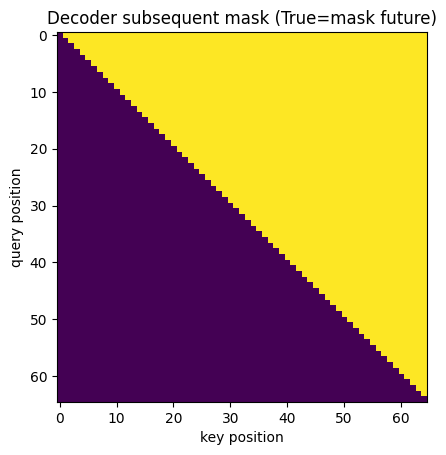

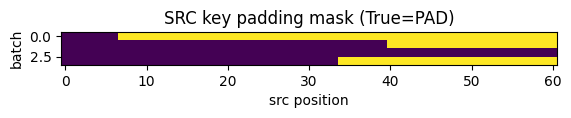

In [13]:
from torch.utils.data import DataLoader

train_loader_tok = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda b: collate_fn_space(b, src_stoi, tgt_stoi, max_src_len=128, max_tgt_len=128)
)

batch = next(iter(train_loader_tok))

for k, v in batch.items():
    if torch.is_tensor(v):
        print(k, v.shape, v.dtype)
    else:
        print(k, type(v), v)

print("\n示例 src ids[0]:", batch["src"][0][:30].tolist())
print("示例 tgt_in ids[0]:", batch["tgt_in"][0][:30].tolist())
print("示例 tgt_out ids[0]:", batch["tgt_out"][0][:30].tolist())

# 可视化 masks（可选）
plt.figure()
plt.imshow(batch["tgt_sub_mask"].cpu().numpy())
plt.title("Decoder subsequent mask (True=mask future)")
plt.xlabel("key position")
plt.ylabel("query position")
plt.show()

plt.figure()
plt.imshow(batch["src_key_padding_mask"].cpu().numpy())
plt.title("SRC key padding mask (True=PAD)")
plt.xlabel("src position")
plt.ylabel("batch")
plt.show()


In [14]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)  # [L, D]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [L,1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维
        pe = pe.unsqueeze(0)  # [1, L, D]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, L, D]
        L = x.size(1)
        x = x + self.pe[:, :L, :]
        return self.dropout(x)


In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x):
        B, L, D = x.shape
        x = x.view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        return x  # [B,H,L,Dh]

    def _merge_heads(self, x):
        B, H, L, Dh = x.shape
        return x.transpose(1, 2).contiguous().view(B, L, H * Dh)  # [B,L,D]

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None, return_attn=False):
        Q = self._split_heads(self.Wq(q))
        K = self._split_heads(self.Wk(k))
        V = self._split_heads(self.Wv(v))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B,H,Lq,Lk]

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask.unsqueeze(0).unsqueeze(0), float("-inf"))

        if key_padding_mask is not None:
            scores = scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(1), float("-inf"))

        attn = torch.softmax(scores, dim=-1)  # [B,H,Lq,Lk]
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)          # [B,H,Lq,Dh]
        out = self._merge_heads(out)         # [B,Lq,D]
        out = self.Wo(out)

        if return_attn:
            return out, attn
        return out


In [16]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.net(x))

class AddNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))


In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(self, x, src_key_padding_mask=None):
        # Self-attn
        sa = self.self_attn(x, x, x, attn_mask=None, key_padding_mask=src_key_padding_mask)
        x = self.addnorm1(x, sa)
        # FFN
        ff = self.ffn(x)
        x = self.addnorm2(x, ff)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)

        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm3 = AddNorm(d_model, dropout)

        self.last_cross_attn = None  # ✅存起来用于可视化

    def forward(self, x, memory, tgt_sub_mask=None, tgt_key_padding_mask=None, src_key_padding_mask=None):
        sa = self.self_attn(x, x, x, attn_mask=tgt_sub_mask, key_padding_mask=tgt_key_padding_mask)
        x = self.addnorm1(x, sa)

        # ✅拿到 cross-attn 的权重
        ca_out, ca_attn = self.cross_attn(
            x, memory, memory,
            attn_mask=None,
            key_padding_mask=src_key_padding_mask,
            return_attn=True
        )
        self.last_cross_attn = ca_attn  # [B,H,T,S]
        x = self.addnorm2(x, ca_out)

        ff = self.ffn(x)
        x = self.addnorm3(x, ff)
        return x



In [18]:
class TransformerNMT(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8, d_ff=2048,
                 num_layers=6, dropout=0.1, max_len=2048):
        super().__init__()
        self.d_model = d_model

        self.src_emb = nn.Embedding(src_vocab_size, d_model, padding_idx=PAD_ID)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model, padding_idx=PAD_ID)

        self.pos = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)

        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)
        ])

        self.out = nn.Linear(d_model, tgt_vocab_size)

    def encode(self, src, src_key_padding_mask=None):
        x = self.src_emb(src) * math.sqrt(self.d_model)  # [B,S,D]
        x = self.pos(x)
        for layer in self.enc_layers:
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
        return x

    def decode(self, tgt_in, memory, tgt_sub_mask=None, tgt_key_padding_mask=None, src_key_padding_mask=None):
        x = self.tgt_emb(tgt_in) * math.sqrt(self.d_model)  # [B,T,D]
        x = self.pos(x)
        for layer in self.dec_layers:
            x = layer(
                x, memory,
                tgt_sub_mask=tgt_sub_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                src_key_padding_mask=src_key_padding_mask
            )
        return x

    def forward(self, src, tgt_in, src_key_padding_mask=None, tgt_key_padding_mask=None, tgt_sub_mask=None):
        memory = self.encode(src, src_key_padding_mask=src_key_padding_mask)
        dec = self.decode(
            tgt_in, memory,
            tgt_sub_mask=tgt_sub_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            src_key_padding_mask=src_key_padding_mask
        )
        logits = self.out(dec)  # [B,T,V]
        return logits


In [19]:
# 用 cfg 里的 Transformer 超参数（你前面 CFG 若不同，可直接填数字）
model = TransformerNMT(
    src_vocab_size=len(src_itos),
    tgt_vocab_size=len(tgt_itos),
    d_model=512, n_heads=8, d_ff=2048,
    num_layers=6,   # ✅先用2层快速验证能跑，之后再改回6
    dropout=0.1,
    max_len=512
).to(device)

batch = next(iter(train_loader_tok))

src = batch["src"].to(device)
tgt_in = batch["tgt_in"].to(device)
src_kpm = batch["src_key_padding_mask"].to(device)
tgt_kpm = batch["tgt_key_padding_mask"].to(device)
tgt_sub = batch["tgt_sub_mask"].to(device)

with torch.no_grad():
    logits = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)

print("logits:", logits.shape)  # [B, T, V]


logits: torch.Size([4, 36, 50000])


In [20]:
def ids_to_tokens(ids, itos):
    out = []
    for i in ids:
        if i < 0 or i >= len(itos):
            out.append("<bad_id>")
        else:
            out.append(itos[i])
    return out

def show_example_from_batch(batch, idx=0, max_show=60):
    src_ids = batch["src"][idx].tolist()
    tgt_in_ids = batch["tgt_in"][idx].tolist()
    tgt_out_ids = batch["tgt_out"][idx].tolist()

    src_toks = ids_to_tokens(src_ids, src_itos)[:max_show]
    tgt_in_toks = ids_to_tokens(tgt_in_ids, tgt_itos)[:max_show]
    tgt_out_toks = ids_to_tokens(tgt_out_ids, tgt_itos)[:max_show]

    print("SRC ids  :", src_ids[:max_show])
    print("SRC toks :", " ".join(src_toks))
    print()
    print("TGT_IN ids :", tgt_in_ids[:max_show])
    print("TGT_IN toks:", " ".join(tgt_in_toks))
    print()
    print("TGT_OUT ids :", tgt_out_ids[:max_show])
    print("TGT_OUT toks:", " ".join(tgt_out_toks))

batch = next(iter(train_loader_tok))
show_example_from_batch(batch, idx=0, max_show=50)


SRC ids  : [2, 1164, 5378, 1, 206, 4, 1352, 2418, 5, 44, 5607, 1, 1, 21563, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SRC toks : <bos> 随着 天然 <unk> 资源 的 日益 紧张 ， 发展 人工 <unk> <unk> 势在必行 。 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

TGT_IN ids : [2, 24, 18, 74, 217, 9, 626, 92, 6489, 1176, 6, 4, 6886, 6489, 5, 238, 812, 157, 6, 41521, 6489, 36, 584, 74, 8, 74, 7875, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TGT_IN toks: <bos> it is more important to develop new sand sources of the artificial sand , since natural resources of riverine sand have become more and more scarce . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

TGT_OUT ids : [24, 18, 74, 217, 9, 626, 92, 6489, 1176, 6, 4, 6886, 6489, 5, 238, 812, 157, 6, 41521, 6489, 36, 584, 74, 8, 74, 7875, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TGT_OUT toks: it is more important to develop new sand sources of the artificial sand , since natu

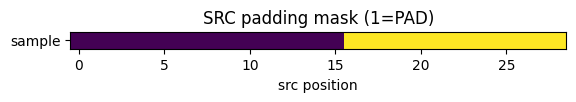

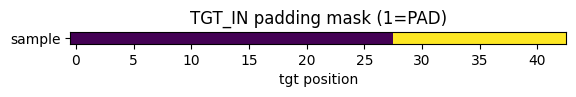

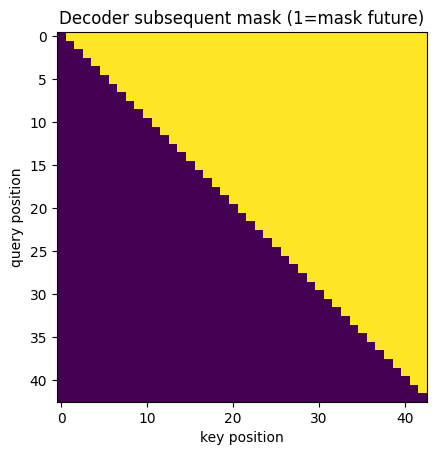

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def show_masks(batch, idx=0):
    src_kpm = batch["src_key_padding_mask"][idx].cpu().numpy().astype(int)  # [S]
    tgt_kpm = batch["tgt_key_padding_mask"][idx].cpu().numpy().astype(int)  # [T]
    sub = batch["tgt_sub_mask"].cpu().numpy().astype(int)                   # [T,T]

    plt.figure()
    plt.imshow(src_kpm[None, :])
    plt.title("SRC padding mask (1=PAD)")
    plt.yticks([0], ["sample"])
    plt.xlabel("src position")
    plt.show()

    plt.figure()
    plt.imshow(tgt_kpm[None, :])
    plt.title("TGT_IN padding mask (1=PAD)")
    plt.yticks([0], ["sample"])
    plt.xlabel("tgt position")
    plt.show()

    plt.figure()
    plt.imshow(sub)
    plt.title("Decoder subsequent mask (1=mask future)")
    plt.xlabel("key position")
    plt.ylabel("query position")
    plt.show()

show_masks(batch, idx=0)


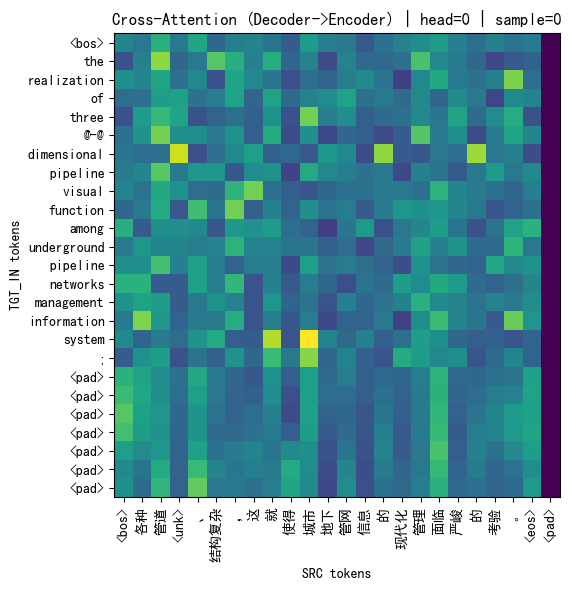

In [22]:
# ========== 中文显示（尽量兼容 Windows 常见字体） ==========
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
def plot_cross_attention(model, batch, sample_idx=0, head_idx=0, max_src=40, max_tgt=25):
    model.eval()
    with torch.no_grad():
        src = batch["src"].to(device)
        tgt_in = batch["tgt_in"].to(device)
        src_kpm = batch["src_key_padding_mask"].to(device)
        tgt_kpm = batch["tgt_key_padding_mask"].to(device)
        tgt_sub = batch["tgt_sub_mask"].to(device)

        _ = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)

    # 拿最后一层 decoder 的 cross-attn
    last_layer = model.dec_layers[-1]
    attn = last_layer.last_cross_attn  # [B,H,T,S]
    attn = attn[sample_idx, head_idx].detach().cpu().numpy()  # [T,S]

    # 取 token 文本
    src_ids = batch["src"][sample_idx].tolist()
    tgt_ids = batch["tgt_in"][sample_idx].tolist()

    src_toks = ids_to_tokens(src_ids, src_itos)[:max_src]
    tgt_toks = ids_to_tokens(tgt_ids, tgt_itos)[:max_tgt]

    attn = attn[:len(tgt_toks), :len(src_toks)]

    plt.figure(figsize=(12, 6))
    plt.imshow(attn)
    plt.title(f"Cross-Attention (Decoder->Encoder) | head={head_idx} | sample={sample_idx}")
    plt.xlabel("SRC tokens")
    plt.ylabel("TGT_IN tokens")
    plt.xticks(range(len(src_toks)), src_toks, rotation=90)
    plt.yticks(range(len(tgt_toks)), tgt_toks)
    plt.tight_layout()
    plt.show()

# 先确保 model 已经重新实例化或重新运行了相关 cell（因为我们改了类定义）
batch = next(iter(train_loader_tok))
plot_cross_attention(model, batch, sample_idx=0, head_idx=0)
